# Personal Information
Name: Felix Atsma

StudentID: 11035064

Email: [**felix.atsma@student.uva.nl**](felix.atsma@student.uva.nl)

Submitted on: **23.03.2025**

Github: https://github.com/felixatsma/Thesis-EDA

# Data Context
Recently, researchers at the Amsterdam UMC have developed a three-dimensional biological model of CLL in the lymph node that mirrors the cellular makeup and includes soluble factors that are similar to the extracellular microenvironment. This model has allowed them to grow 3D spheroids of CLL cells in an environment that mimics their native environment, which presents new research scenarios into CLL proliferation and enables high-throughput drug screening.
The drug screenings consist of growing a spheroid in the model and adding a compound or drug. The spheroid is then imaged over time to capture physical changes in its structure, and afterwards the sample is analyzed for markers for cell activation, which indicates the cancerous cells’ activity. 

# Data Description

The imaging dataset is provided by the Amsterdam UMC and consists of sequences of images of CLL spheroids, around 60,000 images
in total. The dataset is made up of multiple experiments, primarily drug screenings, where various drugs are added to spheroids consisting of healthy lymphocytes and CLL cells,
taken from a patient sample. These are imaged over a range of time at constant intervals, generating a sequence of bright-field images. Some metadata will be provided, including
patient information such as age and lymphocyte percentage from a sample, and whether a certain genetic mutation related to CLL pathogenesis is present (13q14 deletion). Metadata
includes the drug used, its concentration, and post-experiment measurements of specific factors indicating cell activation, which is what we'll attempt to predict.
There are about 100 annotated images provided with segmentation masks, which is a small amount relative to the total set of images.
In this exploratory data analysis, we will mostly be looking at the metadata, as the images part of the dataset consists of just raw, unannotated images.

Not all the metadata has been provided yet, but we'll analyse what we have.

<!---
**Present here the results of your exploratory data analysis. Note that there is no need to have a "story line" - it is more important that you show your understanding of the data and the methods that you will be using in your experiments (i.e. your methodology).**

**As an example, you could show data, label, or group balances, skewness, and basic characterizations of the data. Information about data frequency and distributions as well as results from reduction mechanisms such as PCA could be useful. Furthermore, indicate outliers and how/why you are taking them out of your samples, if you do so.**

**The idea is, that you conduct this analysis to a) understand the data better but b) also to verify the shapes of the distributions and whether they meet the assumptions of the methods that you will attempt to use. Finally, make good use of images, diagrams, and tables to showcase what information you have extracted from your data.**

As you can see, you are in a jupyter notebook environment here. This means that you should focus little on writing text and more on actually exploring your data. If you need to, you can use the amsmath environment in-line: $e=mc^2$ or also in separate equations such as here:

\begin{equation}
    e=mc^2 \mathrm{\space where \space} e,m,c\in \mathbb{R}
\end{equation}

Furthermore, you can insert images such as your data aggregation diagrams like this:

![image](example.png)
--->

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

### Data Loading

In [151]:
df1 = pd.read_excel("../Data/Template_IncuCyte_metadata_list_for_AI_model_MH.xlsx")
df2 = pd.read_excel("../Data/Drug screen 1 - Pooled AI metadata.xlsx", sheet_name=None)
df_tmp = pd.concat([df2[key] for key in df2.keys()], ignore_index=True)
data_df = pd.concat([df1, df_tmp], ignore_index=True)
print(data_df.columns)
data_df

Index(['Experiment', 'Well', 'Volgnummer', 'Sex', 'Birth year', 'Sample date',
       'Age', 'IGHV', 'Rai Stage', 'Stimulation', 'Treatment', 'Target',
       'Concentration (nM)', 'Tissue', 'Viability (%)', '%CD5+CD19+', '%CD4+',
       '%CD8+', '%CD25high (CLL)', '%CD25high (CD4)', '%CD25high (CD8)',
       'gMFI CD25 (CLL)', 'gMFI CD25 (CD4)', 'gMFI CD25 (CD8)',
       '%CD95high (CLL)', '%CD95high (CD4)', '%CD95high (CD8)',
       'gMFI CD95 (CLL)', 'gMFI CD95 (CD4)', 'gMFI CD95 (CD8)', 'WBC (G/L)',
       '%Lymphocytes', 'Hb (mmol/L)', 'Thrombocytes (G/L)', 'del13q14',
       'Previous treatments', 'Future treatments', 'VID', 'CMV', 'EBV', 'HIV',
       'HLA typering', 'HLA typering A2', 'HLA typering A3', 'HLA typering B7',
       'HLA typering B8', 'HLA typering B35', 'del17p13', 'del11q22',
       'trisomy12', 'delATM', 'del14q32', 'TP53', 'delTP53', 'delSF3B1',
       'HLA A2', 'HLA A3', 'HLA B7', 'HLA B8', 'HLA B35',
       'Specific lysis (%)'],
      dtype='object')


,Experiment,Well,Volgnummer,Sex,Birth year,Sample date,Age,IGHV,Rai Stage,Stimulation,...,del14q32,TP53,delTP53,delSF3B1,HLA A2,HLA A3,HLA B7,HLA B8,HLA B35,Specific lysis (%)
0,20230802_JLR18_Drug screen,A1,1199.0,male,1940.0,2012-05-08,72.0,mutated,0.0,unstimulated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20230802_JLR18_Drug screen,A2,1199.0,male,1940.0,2012-05-08,72.0,mutated,0.0,unstimulated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20230802_JLR18_Drug screen,A3,1199.0,male,1940.0,2012-05-08,72.0,mutated,0.0,unstimulated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20230802_JLR18_Drug screen,A4,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20230802_JLR18_Drug screen,A5,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,20240325_JLR13_BH3 mimetics,H8,1792.0,male,1954.0,2016-08-23,62.0,NaN,1.0,3T40 overnight,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.653543
1616,20240325_JLR13_BH3 mimetics,H9,1336.0,female,1938.0,2013-04-11,75.0,mutated,1.0,3T40 overnight,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.772080
1617,20240325_JLR13_BH3 mimetics,H10,1336.0,female,1938.0,2013-04-11,75.0,mutated,1.0,3T40 overnight,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.373219
1618,20240325_JLR13_BH3 mimetics,H11,1336.0,female,1938.0,2013-04-11,75.0,mutated,1.0,3T40 overnight,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.837607


Some of the columns are known before the experiment, the first three are experiment and patient identifiers: 'Experiment', 'Well', 'Volgnummer'.
Others provide information about the patient and treatment tested and as such could be useful as model input. These are: 'Sex', 'Birth year', 'Sample date', 'Age', 'IGHV', 'Rai Stage', 'Stimulation', 'Treatment', 'Target', 'Concentration (nM)', 'Tissue'.
Some specify genetic markers: 'del13q14', 'Previous treatments', 'Future treatments', 'VID', 'CMV', 'EBV', 'HIV', 'HLA typering', 'HLA typering A2', 'HLA typering A3', 'HLA typering B7', 'HLA typering B8', 'HLA typering B35', 'del17p13', 'del11q22', 'trisomy12', 'delATM', 'del14q32', 'TP53', 'delTP53', 'delSF3B1', 'HLA A2', 'HLA A3', 'HLA B7', 'HLA B8', 'HLA B35'.
And the remaining are post-experiment measurements, which are the response variables we will attempt to predict: Viability (%)', '%CD5+CD19+', '%CD4+', '%CD8+', '%CD25high (CLL)', '%CD25high (CD4)', '%CD25high (CD8)', 'gMFI CD25 (CLL)', 'gMFI CD25 (CD4)', 'gMFI CD25 (CD8)', '%CD95high (CLL)', '%CD95high (CD4)', '%CD95high (CD8)', 'gMFI CD95 (CLL)', 'gMFI CD95 (CD4)', 'gMFI CD95 (CD8)', 'WBC (G/L)', '%Lymphocytes', 'Hb (mmol/L)', 'Thrombocytes (G/L)'.

In [133]:
print(data_df.shape)
data_df.describe()

(1620, 61)


,Volgnummer,Birth year,Sample date,Age,Rai Stage,Viability (%),%CD5+CD19+,%CD4+,%CD8+,%CD25high (CLL),...,gMFI CD95 (CD4),gMFI CD95 (CD8),WBC (G/L),%Lymphocytes,Hb (mmol/L),Thrombocytes (G/L),Previous treatments,Future treatments,TP53,Specific lysis (%)
count,1290.000000,1290.000000,1290,1290.000000,1185.000000,1032.000000,1201.000000,1201.000000,1201.000000,603.000000,...,603.000000,603.000000,1279.000000,1259.000000,167.000000,167.000000,1213.000000,1213.000000,0.0,429.000000
mean,1064.586047,1941.000000,2011-08-13 06:46:19.534883584,72.872868,0.453165,56.068634,67.017644,12.519717,6.172858,81.939801,...,1920.502488,3199.091211,23.934918,64.612629,8.647904,239.604790,0.303380,0.234130,NaN,45.010766
min,64.000000,1923.000000,2004-12-16 00:00:00,61.000000,0.000000,0.060000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,9.500000,45.000000,8.000000,217.000000,0.000000,0.000000,NaN,-6.906475
25%,721.000000,1938.000000,2008-12-18 00:00:00,68.000000,0.000000,35.250000,55.890000,8.000000,3.500000,92.000000,...,739.000000,1000.000000,13.800000,58.200000,8.500000,217.000000,0.000000,0.000000,NaN,12.567714
50%,1119.000000,1940.000000,2011-10-19 00:00:00,72.000000,0.000000,62.750000,69.800000,10.260000,5.000000,98.200000,...,1214.000000,1520.000000,18.100000,62.700000,8.500000,231.000000,0.000000,0.000000,NaN,39.770115
75%,1328.000000,1945.000000,2013-04-11 00:00:00,79.000000,1.000000,78.500000,80.700000,16.200000,7.860000,99.300000,...,1714.000000,2260.000000,21.000000,73.600000,9.400000,231.000000,0.000000,0.000000,NaN,77.440633
max,2089.000000,1954.000000,2019-09-17 00:00:00,87.000000,2.000000,98.300000,91.400000,59.200000,21.900000,100.000000,...,13797.000000,30130.000000,97.400000,88.500000,9.400000,288.000000,3.000000,1.000000,NaN,99.905512
std,432.576406,7.935543,NaN,7.287361,0.750929,26.960768,16.639390,7.481423,3.643620,33.277153,...,2586.797693,6440.409878,21.318151,11.987979,0.517622,26.577452,0.816677,0.423629,NaN,34.095626


Not every measurement was performed at every experiment, as seen in the difference in count per column. Many entries are empty as seen by the difference in the amount of rows and the count of 'Volgnummer', which is the patient identifier. These experiments are done using samples contained in wells, as specified in the 'Well' column, but certain wells were unused but these are still included in the dataset. A lack of 'Volgnummer' means that that well and corresponding entry is unused and can be discarded.

In [153]:
data_df = data_df.dropna(subset=['Volgnummer'])
data_df.shape

(1290, 61)

### Analysis 1: 
Checking distributions of the target values

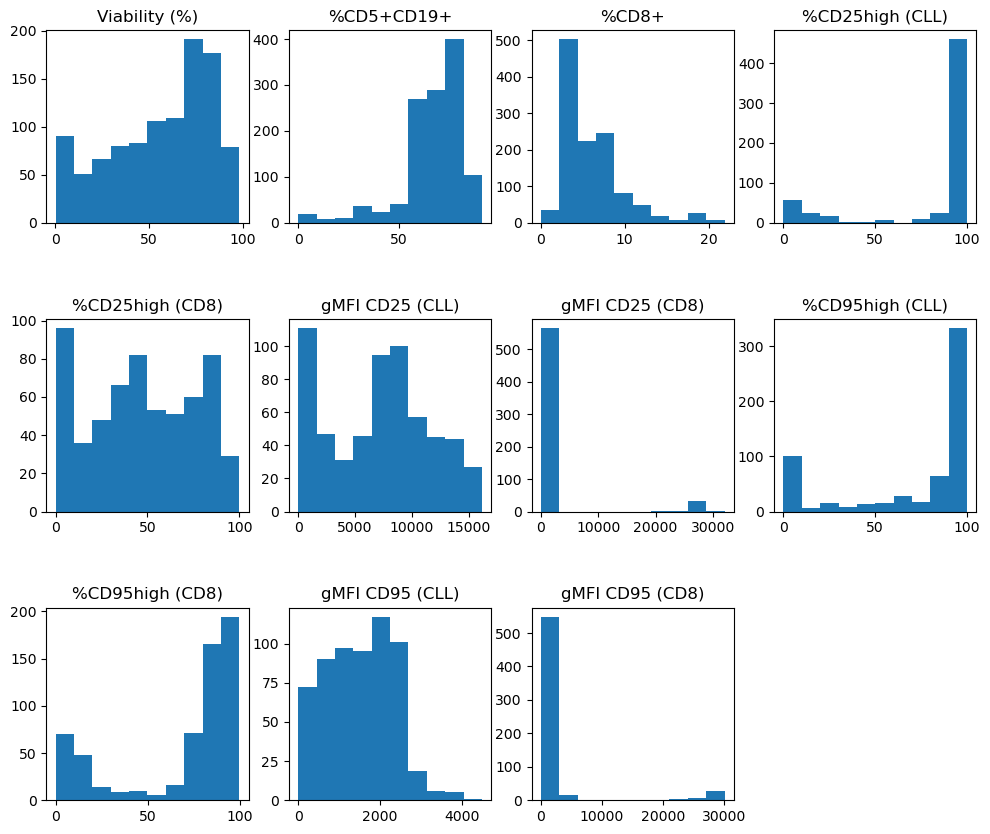

In [165]:
plt.figure(figsize=(12, 10))
plt.subplots_adjust(hspace=0.5)
columns = ['Viability (%)', '%CD5+CD19+', '%CD8+',
       '%CD25high (CLL)', '%CD25high (CD8)',
       'gMFI CD25 (CLL)', 'gMFI CD25 (CD8)',
       '%CD95high (CLL)', '%CD95high (CD8)',
       'gMFI CD95 (CLL)', 'gMFI CD95 (CD8)']

for i, column in enumerate(columns):
    ax = plt.subplot(3, 4, i + 1)
    ax.set_title(column)
    ax.hist(data_df[column].dropna(), alpha=1)

The distribution for some values is very skewed and shows a bimodal distribution.

### Analysis 2: 

Checking for class imbalances.

In [176]:
variables = ['Volgnummer', 'IGHV', 'Stimulation', 'Treatment', 'Target', 'Concentration (nM)', 'Tissue']

for var in variables:
    print(data_df[var].value_counts())
    #plt.figure(figsize=(8,5))
    #plt.hist(data_df[var].value_counts())
    #plt.show()

Volgnummer
1043.0    138
1119.0    124
1328.0    111
1199.0    111
267.0     108
708.0      82
721.0      82
706.0      82
1358.0     63
1336.0     59
1792.0     59
937.0      48
2089.0     48
1553.0     35
839.0      34
1372.0     28
64.0       24
1299.0     14
1148.0     10
1462.0     10
1255.0     10
1120.0     10
Name: count, dtype: int64
IGHV
mutated      904
unmutated    108
Name: count, dtype: int64
Stimulation
IL-2/15/21/CpG     865
unstimulated       162
3T40 overnight     143
aCD3/aCD28          60
3T40 co-culture     60
Name: count, dtype: int64
Treatment
ABT-199                      68
trametinib                   65
S-63845;A-1331852            56
S-63845                      56
A-1331852                    56
ABT-199;S-63845              56
ABT-199;A-1331852            56
ABT-199;S-63845;A-1331852    54
idelalisib                   44
CW15337                      42
Bay 11-7082                  40
momelotinib                  40
ruxolitinib                  40
U0126      